In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import Input

from keras.metrics import mean_squared_error
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/ai_project/data/f10-7.pkl', 'rb') as f:
    df = pickle.load(f)

n = 30 # 30일간 데이터 input
test_num = 10 # 10일간 데이터 output

df_forplot = df[-test_num:]
df = df[:-test_num]

temp_data = df['value'].values

scaler = MinMaxScaler()
temp_data_scaled = scaler.fit_transform(temp_data.reshape(-1, 1))[:, 0]

# 이후 10일 데이터 예측
X_scaled = np.array([temp_data_scaled[i:i+n] for i in range(len(df)-n-test_num+1)])
y_scaled = np.array([temp_data_scaled[i+n:i+n+test_num] for i in range(len(df)-n-test_num+1)])

# plt.plot(df['value'].values[:100])
# plt.plot(X[0], color='orange')
# plt.plot(range(30, 30+test_num), y[0], color='green')
# plt.xticks([10*i for i in range(11)])
# plt.grid(True)

X_scaled = X_scaled.reshape((-1, n, 1))
y_scaled = y_scaled.reshape((-1, 10, 1))

def plot_result(his):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(his.history['loss'])
    ax1.plot(his.history['val_loss'])
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper right')

    ax2.plot(his.history['mae'])
    ax2.plot(his.history['val_mae'])
    ax2.set_title('Model MAE')
    ax2.set_ylabel('MAE')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.show()

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(np.array(X_scaled), np.array(y_scaled), test_size=0.2, random_state=42)

mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()

Mounted at /content/drive


In [ ]:
mae = tf.keras.losses.MeanAbsoluteError()

# Model 1 - ED, MinMaxScaler, GRU(200), 60 epochs

In [ ]:
hidden_size = 200

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, Dense

# Encoder
encoder_inputs = Input(shape=(30, 1))  # 30 time steps
encoder = LSTM(hidden_size, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = RepeatVector(10)(encoder_outputs)  # 10 time steps
decoder_lstm = LSTM(hidden_size, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(1)
decoder_outputs = decoder_dense(decoder_outputs)

model1 = Model(encoder_inputs, decoder_outputs)

model1.compile(loss='mse', optimizer='adam', metrics=['mae'])

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 1)]              0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 200),                161600    ['input_1[0][0]']             
                              (None, 200),                                                        
                              (None, 200)]                                                        
                                                                                                  
 repeat_vector (RepeatVecto  (None, 10, 200)              0         ['lstm[0][0]']                
 r)                                                                                           

In [ ]:
history1 = model1.fit(X_train_scaled, y_train_scaled,
                    epochs=60,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/60
519/519 [==============================] - 17s 13ms/step - loss: 0.0029 - mae: 0.0350 - val_loss: 0.0022 - val_mae: 0.0290
Epoch 2/60
519/519 [==============================] - 10s 20ms/step - loss: 0.0022 - mae: 0.0304 - val_loss: 0.0020 - val_mae: 0.0291
Epoch 3/60
519/519 [==============================] - 5s 10ms/step - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0024 - val_mae: 0.0335
Epoch 4/60
519/519 [==============================] - 6s 12ms/step - loss: 0.0020 - mae: 0.0291 - val_loss: 0.0019 - val_mae: 0.0277
Epoch 5/60
519/519 [==============================] - 5s 10ms/step - loss: 0.0020 - mae: 0.0291 - val_loss: 0.0022 - val_mae: 0.0316
Epoch 6/60
519/519 [==============================] - 5s 10ms/step - loss: 0.0020 - mae: 0.0290 - val_loss: 0.0020 - val_mae: 0.0290
Epoch 7/60
519/519 [==============================] - 8s 16ms/step - loss: 0.0020 - mae: 0.0292 - val_loss: 0.0020 - val_mae: 0.0277
Epoch 8/60
519/519 [==============================] - 8s 15ms/step 

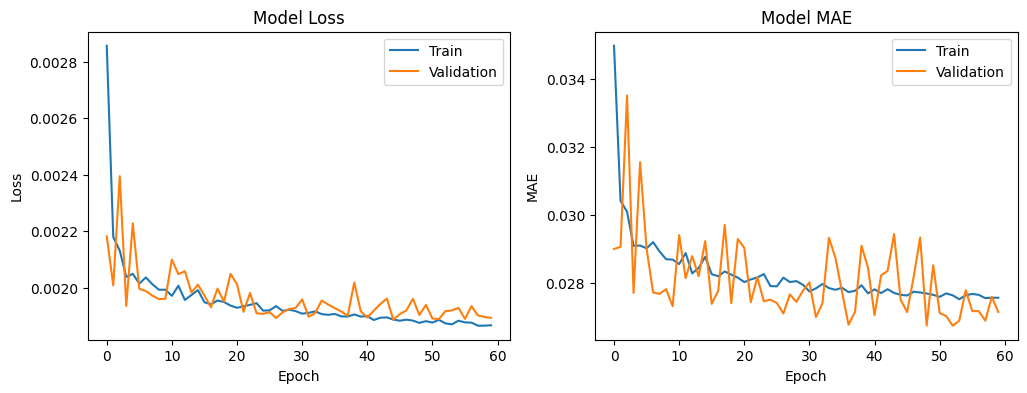

In [ ]:
plot_result(history1)

In [ ]:
pred1 = model1.predict(X_test_scaled)

163/163 [==============================] - 1s 4ms/step


In [ ]:
def scaling_inverse(ar, scaler):
  temp_list = []
  for i in ar:
    temp_list.append(scaler.inverse_transform(i))
  return np.array(temp_list)

In [ ]:
pred1_ori = scaling_inverse(pred1, scaler)
pred1_ori[0]

array([[71.756355],
       [72.98719 ],
       [73.86396 ],
       [74.53209 ],
       [75.22053 ],
       [75.72885 ],
       [76.051346],
       [76.2772  ],
       [76.5469  ],
       [76.97666 ]], dtype=float32)

In [ ]:
y_test_ori = scaling_inverse(y_test_scaled, scaler)
y_test_ori[0]

array([[72.5],
       [71.6],
       [72.1],
       [72.3],
       [71.5],
       [71.1],
       [72.5],
       [71.5],
       [70.5],
       [70.5]])

In [ ]:
mse(pred1_ori, y_test_ori)

<tf.Tensor: shape=(), dtype=float64, numpy=283.8733933765786>

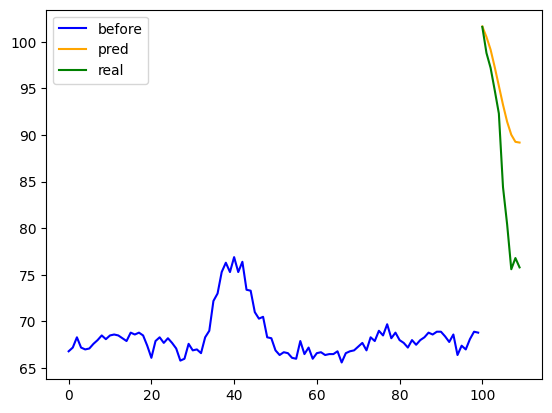

In [ ]:
left_num = 100

i = 701

plt.plot(df['value'].values[-left_num-test_num:-test_num], label='before', color='blue')
plt.plot(range(left_num, left_num+test_num), pred1_ori[i], label='pred', color='orange')
plt.plot(range(left_num, left_num+test_num), y_test_ori[i], label='real', color='green')
plt.legend()

In [ ]:
model1.save('/content/drive/My Drive/ai_project/model/seq2seq_ed_2-1.keras')

# Model 2 - ED, MinMaxScaler, GRU(200), 100 epochs

In [ ]:
hidden_size = 200

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, Dense

# Encoder
encoder_inputs = Input(shape=(30, 1))  # 30 time steps
encoder = LSTM(hidden_size, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = RepeatVector(10)(encoder_outputs)  # 10 time steps
decoder_lstm = LSTM(hidden_size, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(1)
decoder_outputs = decoder_dense(decoder_outputs)

model2 = Model(encoder_inputs, decoder_outputs)

model2.compile(loss='mse', optimizer='adam', metrics=['mae'])

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30, 1)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               [(None, 200),                161600    ['input_2[0][0]']             
                              (None, 200),                                                        
                              (None, 200)]                                                        
                                                                                                  
 repeat_vector_1 (RepeatVec  (None, 10, 200)              0         ['lstm_2[0][0]']              
 tor)                                                                                       

In [ ]:
history2 = model2.fit(X_train_scaled, y_train_scaled,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/100
519/519 [==============================] - 11s 15ms/step - loss: 0.0029 - mae: 0.0355 - val_loss: 0.0022 - val_mae: 0.0295
Epoch 2/100
519/519 [==============================] - 5s 9ms/step - loss: 0.0022 - mae: 0.0308 - val_loss: 0.0022 - val_mae: 0.0310
Epoch 3/100
519/519 [==============================] - 5s 9ms/step - loss: 0.0021 - mae: 0.0298 - val_loss: 0.0021 - val_mae: 0.0289
Epoch 4/100
519/519 [==============================] - 7s 14ms/step - loss: 0.0021 - mae: 0.0293 - val_loss: 0.0020 - val_mae: 0.0292
Epoch 5/100
519/519 [==============================] - 5s 9ms/step - loss: 0.0021 - mae: 0.0293 - val_loss: 0.0020 - val_mae: 0.0276
Epoch 6/100
519/519 [==============================] - 5s 9ms/step - loss: 0.0020 - mae: 0.0285 - val_loss: 0.0020 - val_mae: 0.0278
Epoch 7/100
519/519 [==============================] - 7s 13ms/step - loss: 0.0020 - mae: 0.0288 - val_loss: 0.0019 - val_mae: 0.0275
Epoch 8/100
519/519 [==============================] - 5s 9ms/ste

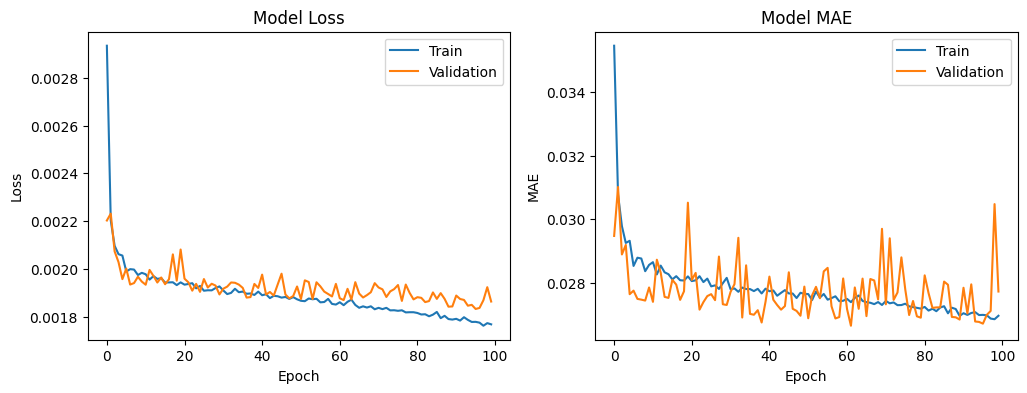

In [ ]:
plot_result(history2)

In [ ]:
pred2 = model2.predict(X_test_scaled)

163/163 [==============================] - 1s 4ms/step


In [ ]:
def scaling_inverse(ar, scaler):
  temp_list = []
  for i in ar:
    temp_list.append(scaler.inverse_transform(i))
  return np.array(temp_list)

In [ ]:
pred2_ori = scaling_inverse(pred2, scaler)
pred2_ori[0]

array([[74.53487 ],
       [74.87295 ],
       [75.62563 ],
       [76.101944],
       [76.56907 ],
       [76.87379 ],
       [77.070885],
       [77.202286],
       [77.330444],
       [77.50585 ]], dtype=float32)

In [ ]:
y_test_ori = scaling_inverse(y_test_scaled, scaler)
y_test_ori[0]

array([[72.5],
       [71.6],
       [72.1],
       [72.3],
       [71.5],
       [71.1],
       [72.5],
       [71.5],
       [70.5],
       [70.5]])

In [ ]:
mse(pred2_ori, y_test_ori)

<tf.Tensor: shape=(), dtype=float64, numpy=281.6556921830635>

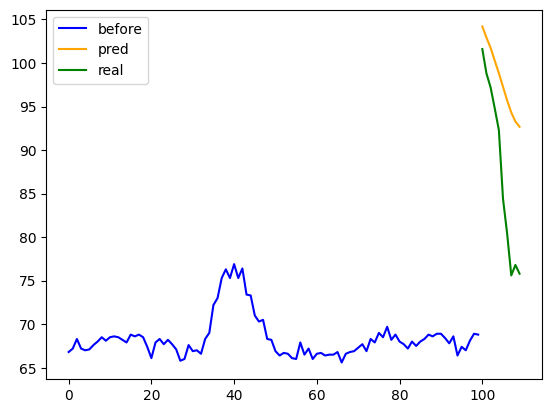

In [ ]:
left_num = 100

i = 701

plt.plot(df['value'].values[-left_num-test_num:-test_num], label='before', color='blue')
plt.plot(range(left_num, left_num+test_num), pred2_ori[i], label='pred', color='orange')
plt.plot(range(left_num, left_num+test_num), y_test_ori[i], label='real', color='green')
plt.legend()

In [ ]:
model2.save('/content/drive/My Drive/ai_project/model/seq2seq_ed_2-2.keras')

# Model 3 - ED, MinMaxScaler, GRU(200), 100 epochs, earlystopping

In [ ]:
hidden_size = 200

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, Dense

# Encoder
encoder_inputs = Input(shape=(30, 1))  # 30 time steps
encoder = LSTM(hidden_size, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = RepeatVector(10)(encoder_outputs)  # 10 time steps
decoder_lstm = LSTM(hidden_size, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(1)
decoder_outputs = decoder_dense(decoder_outputs)

model3 = Model(encoder_inputs, decoder_outputs)

model3.compile(loss='mse', optimizer='adam', metrics=['mae'])

model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30, 1)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               [(None, 200),                161600    ['input_2[0][0]']             
                              (None, 200),                                                        
                              (None, 200)]                                                        
                                                                                                  
 repeat_vector_1 (RepeatVec  (None, 10, 200)              0         ['lstm_2[0][0]']              
 tor)                                                                                       

In [ ]:
from keras.callbacks import EarlyStopping

custom_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
history3 = model3.fit(X_train_scaled, y_train_scaled,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[custom_early_stopping])

Epoch 1/100
519/519 [==============================] - 10s 10ms/step - loss: 0.0030 - mae: 0.0359 - val_loss: 0.0021 - val_mae: 0.0295
Epoch 2/100
519/519 [==============================] - 6s 11ms/step - loss: 0.0022 - mae: 0.0307 - val_loss: 0.0021 - val_mae: 0.0295
Epoch 3/100
519/519 [==============================] - 6s 11ms/step - loss: 0.0021 - mae: 0.0297 - val_loss: 0.0021 - val_mae: 0.0295
Epoch 4/100
519/519 [==============================] - 4s 8ms/step - loss: 0.0021 - mae: 0.0293 - val_loss: 0.0020 - val_mae: 0.0284
Epoch 5/100
519/519 [==============================] - 5s 9ms/step - loss: 0.0020 - mae: 0.0290 - val_loss: 0.0020 - val_mae: 0.0286
Epoch 6/100
519/519 [==============================] - 6s 12ms/step - loss: 0.0020 - mae: 0.0290 - val_loss: 0.0021 - val_mae: 0.0283
Epoch 7/100
519/519 [==============================] - 5s 9ms/step - loss: 0.0020 - mae: 0.0292 - val_loss: 0.0020 - val_mae: 0.0278
Epoch 8/100
519/519 [==============================] - 5s 9ms/st

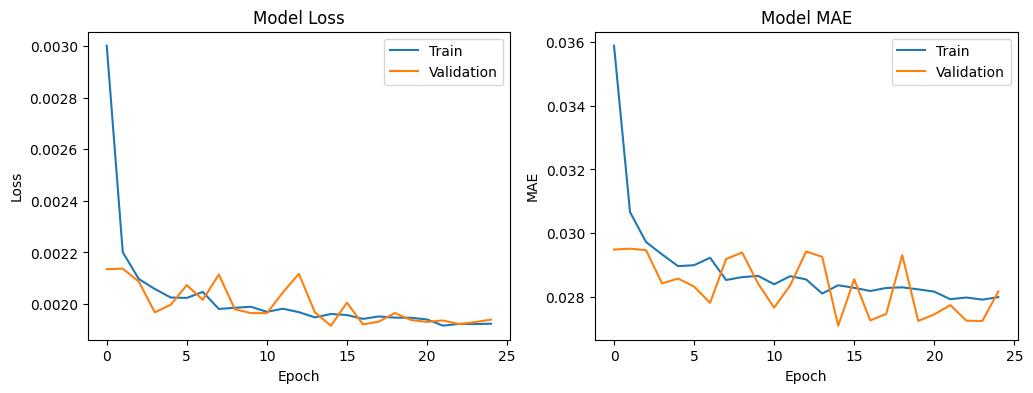

In [ ]:
plot_result(history3)

In [ ]:
# prediction(MinMaxScaled)

test_data_X = X_test_scaled
test_data_y = y_test_scaled

def scaling_inverse(ar, scaler):
  temp_list = []
  for i in ar:
    temp_list.append(scaler.inverse_transform(i))
  return np.array(temp_list)

pred3 = model3.predict(test_data_X)
pred3_ori = scaling_inverse(pred3, scaler)
y_test_ori = scaling_inverse(test_data_y, scaler)
print(mse(pred3_ori, y_test_ori), mae(pred3_ori, y_test_ori))

163/163 [==============================] - 1s 4ms/step
tf.Tensor(285.13297071064176, shape=(), dtype=float64) tf.Tensor(10.566905667851175, shape=(), dtype=float64)


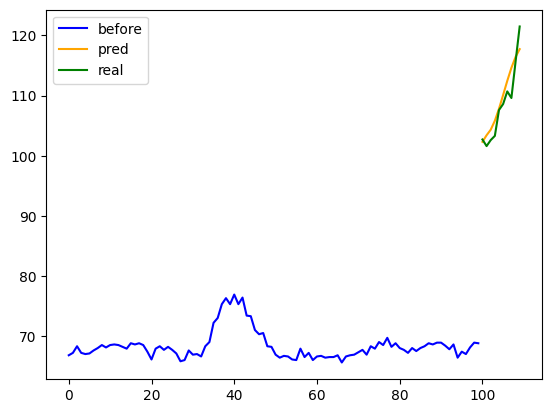

In [ ]:
left_num = 100

i = 712

plt.plot(df['value'].values[-left_num-test_num:-test_num], label='before', color='blue')
plt.plot(range(left_num, left_num+test_num), pred3_ori[i], label='pred', color='orange')
plt.plot(range(left_num, left_num+test_num), y_test_ori[i], label='real', color='green')
plt.legend()

In [ ]:
# model3.save('/content/drive/My Drive/ai_project/model/seq2seq_ed_2-3.keras')

# Model 4

# Model 5

# Model 6

# Model 7